# MATH 578 Lab Assignment 2 <a class="tocSkip">


***Kai Yang***

Original assignment problems are put in *italic fonts*, my text answers are put in **bold fonts**. For both parts, the functions written are in the constructed classes. 

Another interesting thing to note is that, to run the entire thing on GPU, simply use `cupy` instead of `numpy` -- but for the purpose of the assignment, we will stay with `numpy`. The installed `numpy` version at time of completion of this assignment is `1.19.2`.

**All computational functions are consisted in the following class `lab2`, where we assume the matrix to be operated on is denoted by $A\in\mathbb{C}^{n\times m}$.**

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

print("The installed numpy version at time of completion of this assignment is:", np.__version__)

class lab2:
    '''
    Class consisting of all the functions carrying out computation in this assignment. 
    '''
    def __init__(self):
        '''
        Construct the class with the following values:
        self.n, self.m: the target matrix is a n*m matrix
        '''
        self.n, self.m = 0, 0 # initialize values for n, m 
    
    def QR(self, A):
        '''
        (for problem 1) Perform QR factorization on (possibly complex) matrix A using Householder reflections. A post-processing step is included to ensure nonnegativeness of the diagonal entries for R. 
        '''
        self.n, self.m = A.shape[-2:] # A is a n by m matrix
        Q = np.eye(self.n)+0j # ... because numpy will discard imag part of complex numbers if casting into a floating matrix...
        R = A+0j # so that A will not be mutated, also to make sure the data type for R is complex
        for k in np.arange(np.min([self.n, self.m])): # here it's not np.min([self.n-1, self.m]) because we need to adjust the sign of the last diagonal entry to make it nonnegative
            v = R[k:,k].copy()
            temp_sign = np.exp(1j*np.angle(v[0])) # the sign here is chosen to avoid round-off errors -- note temp_sign will be the NEGATIVE of the sign for target reflection
            v[0] += temp_sign*np.linalg.norm(v) # as stated in above line, temp_sign is the NEGATIVE of the sign for reflection
            v /= np.linalg.norm(v) # normalize v
            temp_Q = np.outer(2*v, v.T.conj()) # to reduce numerical errors, instead of multiplying by I-Q', we omit multiplying by identity matrix this way 
            R[k:,k:] -= temp_Q@R[k:,k:] # update R
            temp_Q -= np.eye(self.n-k) # get the real form of temp_Q
            Q[:,k:] = Q[:,k:]@(-temp_Q.T.conj()) # update Q
            R[k,:] /= -temp_sign # post-processing to make diagonal entries are nonnegative, coded this way so we don't have to store the sign
            Q[:,k] *= -temp_sign # in view of sum of outer products for QR, we can do this 
        return Q, R 
    
    def gen_orth_mat(self, n):
        '''
        (for problem 2) Generate a random REAL orthogonal matrix (floating point data type) using QR factorization method:
        n:              dimension of the matrix to be generated
        '''
        A = np.random.rand(n,1) # generate a n by 1 matrix to improve computational and numerical efficiency
        return self.QR(A)[0].astype("float_") # convert data type will discard the imag part, but we are asked to generate real orthogonal matrix anyway
    
    def Hessenberg(self, A):
        '''
        (for problem 3) Reduce a (possibly complex) matrix A to Hessenberg form by orthogonal transformations. 
        '''
        self.n, self.m = A.shape[-2:] # A is a n by m matrix
        Q = np.eye(self.n)+0j # ... because numpy will discard imag part of complex numbers if casting into a floating matrix...
        R = A+0j # so that A will not be mutated, also to make sure the data type for R is complex
        for k in np.arange(np.min([self.n-2, self.m])): # Hessenberg has its sub-diagonal occupied, also because we don't need to worry about the signs anymore 
            v = R[k+1:,k].copy()
            temp_sign = np.exp(1j*np.angle(v[0])) # here temp_sign would be the NEGATIVE sign of sub-diagonal entries to ensure numerical stability
            v[0] += temp_sign*np.linalg.norm(v) # as stated in above line, temp_sign is the NEGATIVE of the sign for reflection
            v /= np.linalg.norm(v) # normalize v
            temp_Q = np.outer(2*v, v.T.conj()) # to reduce numerical errors, instead of multiplying by I-Q', we omit multiplying by identity matrix this way 
            R[k+1:,k:] -= temp_Q@R[k+1:,k:] # update R
            temp_Q -= np.eye(self.n-k-1) # get the real form of temp_Q
            Q[:,k+1:] = Q[:,k+1:]@(-temp_Q.T.conj()) # update Q
        return Q, R
    
    def tri_diag(self, A):
        '''
        (for problem 3) Tri-diagonalize a real symmetric matrix A.
        '''
        self.n = A.shape[0] # A is a n by n sqaure matrix
        Q = np.eye(self.n) 
        R = A.copy() # so that A will not be mutated 
        for k in np.arange(self.n-2): # same as Hessenberg above, just need to zero self.n-2 entries max
            v = R[k+1:,k].copy()
            if v[0]==0:
                temp_sign = -1 # temp_sign is the negative of reflection sign, so here it's -1
            else:
                temp_sign = np.sign(v[0]) # here temp_sign would be the NEGATIVE sign of sub-diagonal entries
            v[0] += temp_sign*np.linalg.norm(v) # as stated in above line, temp_sign is the NEGATIVE of the sign for reflection
            v /= np.linalg.norm(v) # normalize v
            temp_Q = np.outer(2*v, v.T) # to reduce numerical errors, instead of multiplying by I-Q', we omit multiplying by identity matrix this way 
            R[k+1:,k:] -= temp_Q@R[k+1:,k:] # update R from left multiplication
            R[k:,k+1:] -= R[k:,k+1:]@temp_Q # update R from right multiplication. Note that temp_Q is symmetirc, so is the Householder's matrix 
            temp_Q -= np.eye(self.n-k-1) # get the real form of temp_Q
            Q[:,k+1:] = Q[:,k+1:]@(-temp_Q.T) # update Q
        return Q, R
    
    def QR_tri(self, A):
        '''
        (for problem 4) Perform QR factorization for real (symmetric => square) tridiagonal matrix. Comparing to self.QR it is much more efficient.
        '''
        self.n = A.shape[0] # A is a n by n matrix
        Q = np.eye(self.n)
        R = A.copy() # so that A will not be mutated
        for k in np.arange(self.n-1): # zeroing self.n-1 entries max, we don't non-negativize the sign of the lower-right corner entry
            v = R[k:k+2,k].copy()
            if v[0]==0:
                temp_sign = -1
            else:
                temp_sign = np.sign(v[0]) # here temp_sign would be the NEGATIVE sign of sub-diagonal entries
            v[0] += temp_sign*np.linalg.norm(v) # as stated in above line, temp_sign is the NEGATIVE of the sign for reflection
            v /= np.linalg.norm(v) # normalize v
            temp_Q = np.outer(2*v, v.T) # to reduce numerical errors, instead of multiplying by I-Q', we omit multiplying by identity matrix this way 
            R[k:k+2,k:k+3] -= temp_Q@R[k:k+2,k:k+3] # update R
            temp_Q -= np.eye(2) # get the real form of temp_Q
            Q[:k+2,k:k+2] = Q[:k+2,k:k+2]@(-temp_Q.T) # update Q
            R[k,k:k+3] /= -temp_sign # because R only has these three nonzero entries per row
            Q[:k+2,k] *= -temp_sign # because non-identity update for Q is right multiplication of a 2 by 2 matrix 
        if R[-1,-1]<0: # correcting the sign for the lower-right corner
            R[-1,-1] = -R[-1,-1]
            Q[:,-1] = -Q[:,-1]
        return Q, R
    
    def Wilkinson_shift(self, submat):
        '''
        (for self.QR_shift) Calculating Wilkinson shift using a 2 by 2 (real) submatrix
        '''
        temp_Wilkinson = (submat[0,0] - submat[1,1])/2
        if temp_Wilkinson<0:
            shifting = submat[1,1] + submat[1,0]**2/(np.abs(temp_Wilkinson) + np.sqrt(temp_Wilkinson**2 + submat[1,0]**2))
        else:
            shifting = submat[1,1] - submat[1,0]**2/(np.abs(temp_Wilkinson) + np.sqrt(temp_Wilkinson**2 + submat[1,0]**2))
        return shifting
    
    def QR_iter_noshift(self, block):
        '''
        (for self.QR_shift) Perform one QR iteration with no shift directly on input matrix block -- that is, it will mutate A
        '''
        Q, R = self.QR_tri(block)
        block = R@Q
        block[np.tril_indices(block.shape[0], -2)] = 0 # zeroing sub-subdiagonal entries
        block[np.triu_indices(block.shape[0], 2)] = 0 # zeroing super-superdiagonal entries
        np.fill_diagonal(block[:,1:], np.diagonal(block, -1)) # to make tridiagonal block symmetric by copying its subdiagonal entries to superdiagonal 
        return block
    
    def QR_iter_Rayleigh(self, block):
        '''
        (for self.QR_shift) Perform one QR iteration with Rayleigh quotient shift directly on input matrix block -- that is, it will mutate A
        '''
        shifting = block[-1, -1] # calculate Rayleigh quotient shift for the iteration
        np.fill_diagonal(block, np.diagonal(block)-shifting) # shifting
        Q, R = self.QR_tri(block)
        block = R@Q
        np.fill_diagonal(block, np.diagonal(block)+shifting) # shifting back
        block[np.tril_indices(block.shape[0], -2)] = 0 # zeroing sub-subdiagonal entries
        block[np.triu_indices(block.shape[0], 2)] = 0 # zeroing super-superdiagonal entries
        np.fill_diagonal(block[:,1:], np.diagonal(block, -1)) # to make tridiagonal block symmetric by copying its subdiagonal entries to superdiagonal 
        return block
        
    def QR_iter_Wilkinson(self, block):
        '''
        (for self.QR_shift) Perform one QR iteration with Wilkinson shift directly on input matrix block -- that is, it will mutate A
        '''
        shifting = self.Wilkinson_shift(block[-2:, -2:]) # calculate Wilkinson shift for the iteration
        np.fill_diagonal(block, np.diagonal(block)-shifting) # shifting
        Q, R = self.QR_tri(block)
        block = R@Q
        np.fill_diagonal(block, np.diagonal(block)+shifting) # shifting back
        block[np.tril_indices(block.shape[0], -2)] = 0 # zeroing sub-subdiagonal entries
        block[np.triu_indices(block.shape[0], 2)] = 0 # zeroing super-superdiagonal entries
        np.fill_diagonal(block[:,1:], np.diagonal(block, -1)) # to make tridiagonal block symmetric by copying its subdiagonal entries to superdiagonal 
        return block
        
    def QR_shift(self, A, shift="none", tol=1e-10):
        '''
        (for problem 4) Perform QR algorithm with: i). no shift; ii). Rayleigh quotient shift; iii). Wilkinson shift on given real symmetric tridiagonal matrix A 
        shift:          string, choose between "none", "Rayleigh", or "Wilkinson"; default value is "none"
        tol:            floating point scalar; the tolerance parameter for the algorithm to be considered "converged"
        *traj and off_diag components added to support Problem 5 and beyond -- they are marked with a #* comment
        '''
        A_copy = A.copy() # to not mutate A 
        self.n = A_copy.shape[0]
        traj = np.diagonal(A_copy).reshape(1, self.n) #*
        off_diag = np.diagonal(A_copy, -1).reshape(1, self.n-1) #*
        off_diag_bool = (np.abs(np.diagonal(A_copy, -1)) >= tol) # to initialize the off diagonal criteria
        converge = np.logical_not(np.any(off_diag_bool))
        
        while not converge:
            starting = np.where(off_diag_bool)[0][0]
            ending = np.where(np.logical_not(off_diag_bool[starting:]))[0]
            if ending.size==0: # when all following subdiagonal entries are nonzero
                if shift == "none":
                    A_copy[starting:, starting:]=self.QR_iter_noshift(A_copy[starting:, starting:]) 
                elif shift == "Rayleigh":
                    A_copy[starting:, starting:]=self.QR_iter_Rayleigh(A_copy[starting:, starting:]) 
                else:
                    A_copy[starting:, starting:]=self.QR_iter_Wilkinson(A_copy[starting:, starting:]) 
            else:
                ending = starting + ending[0] # because the related diagonal entries goes all the way to the right of the ending nonzero subdiagonal entry
                if shift == "none":
                    A_copy[starting:ending+1, starting:ending+1]=self.QR_iter_noshift(A_copy[starting:ending+1, starting:ending+1]) 
                elif shift == "Rayleigh":
                    A_copy[starting:ending+1, starting:ending+1]=self.QR_iter_Rayleigh(A_copy[starting:ending+1, starting:ending+1]) 
                else:
                    A_copy[starting:ending+1, starting:ending+1]=self.QR_iter_Wilkinson(A_copy[starting:ending+1, starting:ending+1]) 
            traj = np.append(traj, [np.diagonal(A_copy)], axis=0) #*
            off_diag = np.append(off_diag, [np.diagonal(A_copy, -1)], axis=0) #*
            off_diag_bool = (np.abs(np.diagonal(A_copy, -1)) >= tol)
            converge = np.logical_not(np.any(off_diag_bool))
        return np.diagonal(A_copy), traj, off_diag #*
    
    def gen_sym_mat(self, eig_val, seed=0):
        '''
        (for problem 5) Generate symmetric matrix with a given set of eigenvalues:
        eig_val:        floating point numpy array; the vector of eigenvalues for the matrix to be generated
        seed:           scalar; random seed to set with default value 0
        '''
        n = len(eig_val)
        np.random.seed(seed)
        Q = self.gen_orth_mat(n)
        A = Q.T@np.diag(eig_val)@Q
        return A
    
    def problem5(self, eig_val, seed=0, tol=1e-10):
        '''
        A function written ultimately for problem 5. Input eigenvalue array and output errors for all shifting options.
        '''
        A = lab.gen_sym_mat(eig_val = eig_val, seed = seed)
        A = lab.tri_diag(A)[1] # reduce to tri-diagonal form
        A[np.tril_indices(self.n, -2)] = 0 # zeroing sub-subdiagonal entries
        A[np.triu_indices(self.n, 2)] = 0 # zeroing super-superdiagonal entries
        np.fill_diagonal(A[:,1:], np.diagonal(A, -1)) # enforce symmetry
        # no shift
        temp, error_noshift, off_diag_noshift = self.QR_shift(A, tol=tol)
        temp_rank_noshift = temp.argsort().argsort()
        error_noshift -= eig_val[temp_rank_noshift]
        error_noshift = np.abs(error_noshift)
        off_diag_noshift = np.abs(off_diag_noshift)
        # Rayleigh quotient shift
        temp, error_Rayleigh, off_diag_Rayleigh = self.QR_shift(A, shift="Rayleigh", tol=tol)
        temp_rank_Rayleigh = temp.argsort().argsort()
        error_Rayleigh -= eig_val[temp_rank_Rayleigh]
        error_Rayleigh = np.abs(error_Rayleigh)
        off_diag_Rayleigh = np.abs(off_diag_Rayleigh)
        # Wilkinson shift
        temp, error_Wilkinson, off_diag_Wilkinson = self.QR_shift(A, shift="Wilkinson", tol=tol)
        temp_rank_Wilkinson = temp.argsort().argsort()
        error_Wilkinson -= eig_val[temp_rank_Wilkinson]
        error_Wilkinson = np.abs(error_Wilkinson)
        off_diag_Wilkinson = np.abs(off_diag_Wilkinson)
        
        return temp_rank_noshift, error_noshift, off_diag_noshift, temp_rank_Rayleigh, error_Rayleigh, off_diag_Rayleigh, temp_rank_Wilkinson, error_Wilkinson, off_diag_Wilkinson
    
    

The installed numpy version at time of completion of this assignment is: 1.19.2


## Problem 1 

*Implement a function that computes a QR factorization of a given $n\times n$ matrix. You can use either Householder reﬂections or Givens rotations. Do a post-processing to make sure that the diagonal entries of the triangular factor $R$ are nonnegative (This requirement makes the factorization unique). Test it on a number of cases to be sure of its correctness.*

**We choose to use Householder's reflection. As suggested by the textbooks [1, 2], a reflection far from the original point should be picked to avoid loss of significance. The resulting function can be found as `lab2.QR` from above codes -- a function to perform QR decomposition, works for both real and complex matrices. As for the post-processing to makes diagonal entries of $R$ nonnegative, we simply noted that: $$A=QR=\sum^n_{i=1}q_i r^T_i=\sum^n_{i=1}\text{sgn}\left(r_{ii}\right)q_i\frac{r^T_i}{\text{sgn}\left(r_{ii}\right)}$$ where $q_i$ is the $i$th column of $Q$ and $r^T_i$ is the $i$th *row* of $R$, here $\text{sgn}$ is the sign function with $\text{sgn}\left(0\right)=1$.** 

**Here we calculated $\max_{i,j}\left|\left[I-QQ^{*}\right]_{ij}\right|$ and $\max_{i,j}\left|\left[A-QR\right]_{ij}\right|$ to check for orthogonality of $Q$ and multiplication of factors. The numerical errors shown below are small enough to suggest the method is correctly implemented.**

In [2]:
lab = lab2()

np.random.seed(0)
for j in np.arange(5, 11)*10: 
    A = np.random.rand(j,2*j-75) + 1j*np.random.rand(j,2*j-75)
    Q, R = lab.QR(A)
    QQH_error = np.max(np.abs(Q@Q.T.conj()-np.eye(j)))
    QR_error = np.max(np.abs(Q@R-A))
    print("Input matrix A is of shape", A.shape, ", the max error to check for orthogonality of Q is ", QQH_error,"; the max error to check for factor multiplication is ", QR_error, "; all the diagonal entries in R are nonnegative: ", np.all(np.diagonal(R).real>=0), ".", sep="")


Input matrix A is of shape(50, 25), the max error to check for orthogonality of Q is 2.4424906541753444e-15; the max error to check for factor multiplication is 2.383265111561623e-15; all the diagonal entries in R are nonnegative: True.
Input matrix A is of shape(60, 45), the max error to check for orthogonality of Q is 4.218847493575595e-15; the max error to check for factor multiplication is 4.12167961557554e-15; all the diagonal entries in R are nonnegative: True.
Input matrix A is of shape(70, 65), the max error to check for orthogonality of Q is 3.3306690738754696e-15; the max error to check for factor multiplication is 2.531698018113677e-15; all the diagonal entries in R are nonnegative: True.
Input matrix A is of shape(80, 85), the max error to check for orthogonality of Q is 4.884981308350689e-15; the max error to check for factor multiplication is 5.783891694525952e-15; all the diagonal entries in R are nonnegative: True.
Input matrix A is of shape(90, 105), the max error to c

## Problem 2 

*Write a function that generates random orthogonal matrices. This can be done by ﬁrst generating a random matrix $A$, say, with normally distributed entries, and then taking the $Q$-factor of its QR factorization with nonnegative entries on the diagonal of $R$.*

**The function to generate a (real) orthogonal matrix can be found as `lab2.gen_orth_mat` in the codes above. Note that: i). we generated a $n\times 1$ random matrix $A$, then perform QR factorization on $A$ to get the $n\times n$ orthogonal matrix $Q$ -- here we only need one step of QR factorization (because $A$ has only one column), note that *less* QR factorization steps means *better* computational efficiency and numerical stability; ii). by default `numpy.random.rand` generate from uniform r.v. not Gaussian r.v. -- of course, it doesn't really matter here.** 

## Problem 3 

*By modifying your QR factorization code, implement a function that reduces a given $n\times n$ matrix into a Hessenberg form by orthogonal transformations. Implement also a function that turns a given real symmetric matrix into a tridiagonal form. You may want to add a line that forces the output matrix to be exactly symmetric and tridiagonal. Test the functions on a number of cases.*

**To reduce a matrix to Hessenberg form, simply apply Householder's reflection on the (sub-)matrix *except for the first row* per iteration. The implemented function can be found as `lab2.Hessenberg` in above codes -- as a modification from QR factorization implemented before, it also works for any matrix $A\in\mathbb{C}^{n\times m}$, though now there is no post-processing necessary.**

**The function that turns given *real symmetric matrix* $A$ into a tridiagonal form is implemented as `lab2.tri_diag`: $$A=QRQ^T=QRQ$$ because the Householder's matrix $Q$ is symmetric. (Note: should $A$ be nonsymmetric, a Schur form will then be obtained.)**

**Here we use complex matrices to test the function `lab2.Hessenberg`, in addition to the usual QR factorization testing done in Problem 1, we also check the Hessenberg form of $R$ by calculating $$\max_{i>j+1}\left|R_{ij}\right|$$ as for the tridiagonalization problem, we check the tridiagonal form of $R$ by calculating $$\max_{i>j+1}\left|R_{ij}\right|+\left|R_{ji}\right|$$ All errors are small enough to suggest the implementation is correct.**

In [3]:
print("Testing the function lab2.Hessenberg:")
for j in np.arange(5, 11)*10: 
    A = np.random.rand(j,2*j-75) + 1j*np.random.rand(j,2*j-75)
    Q, R = lab.QR(A)
    QQH_error = np.max(np.abs(Q@Q.T.conj()-np.eye(j)))
    QR_error = np.max(np.abs(Q@R-A))
    print("Input matrix A is of shape", A.shape, ", the max error to check for orthogonality of Q is ", QQH_error,"; the max error to check for factor multiplication is ", QR_error, "; the max error to check that R is of Hessenberg form is: ", np.max(np.abs(np.tril(R, k=-2))), ".", sep="")

print("Testing the function lab2.tri_diag:")
for j in np.arange(5, 11)*10: 
    A = np.random.rand(j,j)
    A += A.T
    Q, R = lab.tri_diag(A)
    QQH_error = np.max(np.abs(Q@Q.T-np.eye(j)))
    QR_error = np.max(np.abs(Q@R@Q.T-A))
    print("Input matrix A is of shape", A.shape, ", the max error to check for orthogonality of Q is ", QQH_error,"; the max error to check for factor multiplication is ", QR_error, "; the max error to check that R is of tridiagonal form is: ", np.max(np.abs(np.tril(R, k=-2))+np.abs(np.triu(R, k=2))), ".", sep="")


Testing the function lab2.Hessenberg:
Input matrix A is of shape(50, 25), the max error to check for orthogonality of Q is 3.552713678800501e-15; the max error to check for factor multiplication is 2.434909185329438e-15; the max error to check that R is of Hessenberg form is: 8.671119018262735e-16.
Input matrix A is of shape(60, 45), the max error to check for orthogonality of Q is 3.3306690738754696e-15; the max error to check for factor multiplication is 2.3733857464271978e-15; the max error to check that R is of Hessenberg form is: 5.566705740848049e-16.
Input matrix A is of shape(70, 65), the max error to check for orthogonality of Q is 4.440892098500626e-15; the max error to check for factor multiplication is 2.9873046363423827e-15; the max error to check that R is of Hessenberg form is: 6.473657049138937e-16.
Input matrix A is of shape(80, 85), the max error to check for orthogonality of Q is 5.329070518200751e-15; the max error to check for factor multiplication is 3.88736629553

## Problem 4 

*Write a code that performs the QR algorithm on a given real symmetric tridiagonal matrix. Produce 3 versions: no shift (i.e., basic QR), the Rayleigh quotient shift, and the Wilkinson shift. For greater eﬃciency, you may want to modify your QR factorization code so that it takes advantage of the tridiagonality (and perhaps symmetry as well). You may also wish to enforce exact symmetry and tridiagonality at each step of the QR algorithm.*

**A more efficient QR factorization algorithm for real (symmetric $\Rightarrow$ square) matrix $A$ is implemented as `lab2.tri_diag` -- efficiency is improved by observing the sparse patterns of matrices. For all three QR algorithms implemented, tridiagonality and exact symmetry are enforced per iteration to get rid of some numerical errors. The implemented QR algorithm is `lab2.QR_shift`, where `shift` argument can be chosen from `none`, `Rayleigh`, or `Wilkinson`, tolerance parameter is the upper bound for the sub-diagonal entries absolute values for the final similar matrix. Deflation is used; *as without deflation, QR with both shifts here will not converge.***

## Problem 5 

*Generate a symmetric random matrix with a given set of eigenvalues as $A = Q^T\Lambda Q$, where $Q$ is a random orthogonal matrix, and $\Lambda$ is a diagonal matrix (for example, take $\Lambda = \text{diag}\left(1, 2, . . . , 10\right)$). Please set a ﬁxed seed for the random number generator for reproducibility. Reduce $A$ to a tridiagonal form, and run the QR algorithm on it, by using the functions you implemented. Pick several of the eigenvalues that represent variety of possibilities (that is, one small eigenvalue, one mid-sized eigenvalue, etc.), including the largest eigenvalue, and plot the corresponding errors (in log-scale) against the iteration number. Moreover, plot the size (in log-scale) of the oﬀ-diagonal entries that are close to the position of the chosen eigenvalues against the iteration number. Do this for all 3 versions of the QR algorithm. Comment on your results.*

**A function to generate random real symmetric matrix with eigenvalues `eig_val` is written as `lab2.gen_sym_mat`. We also created a function `lab2.problem5` just for this problem.**

Eigenvalues output rank order for QR with no shift: [9 8 7 6 5 4 3 2 1 0]


/Users/kaiseryet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/kaiseryet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


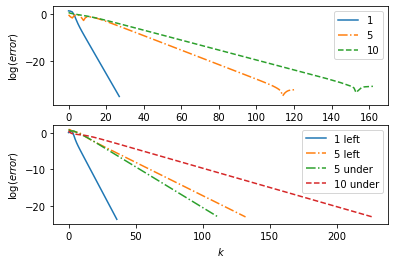

In [4]:
temp_rank_noshift, error_noshift, off_diag_noshift, temp_rank_Rayleigh, error_Rayleigh, off_diag_Rayleigh, temp_rank_Wilkinson, error_Wilkinson, off_diag_Wilkinson = lab.problem5(eig_val = np.arange(1,11))

def filt_duplts(a):
    '''
    A function to remove duplicates of a 1-D array.
    '''
    _, temp2 = np.unique(a, return_index=True)
    return a[np.sort(temp2)]

print("Eigenvalues output rank order for QR with no shift:", temp_rank_noshift)

error_noshift_1 = filt_duplts(error_noshift[:,9])
off_diag_noshift_1_left = filt_duplts(off_diag_noshift[:,8])

error_noshift_5 = filt_duplts(error_noshift[:,4])
off_diag_noshift_5_left = filt_duplts(off_diag_noshift[:,4])
off_diag_noshift_5_under = filt_duplts(off_diag_noshift[:,5])

error_noshift_10 = filt_duplts(error_noshift[:,0])
off_diag_noshift_10_under = filt_duplts(off_diag_noshift[:,0])

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.log(error_noshift_1), '-', label="1")
axs[0].plot(np.log(error_noshift_5), '-.', label="5")
axs[0].plot(np.log(error_noshift_10), '--', label="10")
axs[0].set(ylabel=r"$\log(error)$")
axs[0].legend() # add a legend

axs[1].plot(np.log(off_diag_noshift_1_left), '-', label="1 left")
axs[1].plot(np.log(off_diag_noshift_5_left), '-.', label="5 left")
axs[1].plot(np.log(off_diag_noshift_5_under), '-.', label="5 under")
axs[1].plot(np.log(off_diag_noshift_10_under), '--', label="10 under")
axs[1].legend() # add a legend
axs[1].set(xlabel=r"$k$", ylabel=r"$\log(error)$")

plt.show()


Eigenvalues output rank order for QR with Rayleigh quotient shift: [9 0 8 1 7 2 6 3 5 4]


/Users/kaiseryet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


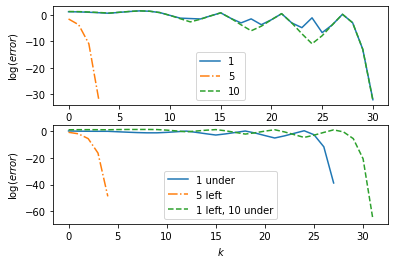

In [5]:
print("Eigenvalues output rank order for QR with Rayleigh quotient shift:", temp_rank_Rayleigh)

error_Rayleigh_1 = filt_duplts(error_Rayleigh[:,1])
off_diag_Rayleigh_1_left_10_under = filt_duplts(off_diag_Rayleigh[:,0])
off_diag_Rayleigh_1_under = filt_duplts(off_diag_Rayleigh[:,1])

error_Rayleigh_5 = filt_duplts(error_Rayleigh[:,9])
off_diag_Rayleigh_5_left = filt_duplts(off_diag_Rayleigh[:,8])

error_Rayleigh_10 = filt_duplts(error_Rayleigh[:,0])

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.log(error_Rayleigh_1), '-', label="1")
axs[0].plot(np.log(error_Rayleigh_5), '-.', label="5")
axs[0].plot(np.log(error_Rayleigh_10), '--', label="10")
axs[0].set(ylabel=r"$\log(error)$")
axs[0].legend() # add a legend

axs[1].plot(np.log(off_diag_Rayleigh_1_under), '-', label="1 under")
axs[1].plot(np.log(off_diag_Rayleigh_5_left), '-.', label="5 left")
axs[1].plot(np.log(off_diag_Rayleigh_1_left_10_under), '--', label="1 left, 10 under")
axs[1].legend() # add a legend
axs[1].set(xlabel=r"$k$", ylabel=r"$\log(error)$")

plt.show()


Eigenvalues output rank order for QR with Wilkinson shift: [9 0 8 1 7 2 6 5 3 4]


/Users/kaiseryet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


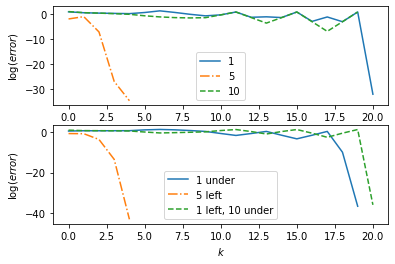

In [6]:
print("Eigenvalues output rank order for QR with Wilkinson shift:", temp_rank_Wilkinson)

error_Wilkinson_1 = filt_duplts(error_Wilkinson[:,1])
off_diag_Wilkinson_1_left_10_under = filt_duplts(off_diag_Wilkinson[:,0])
off_diag_Wilkinson_1_under = filt_duplts(off_diag_Wilkinson[:,1])

error_Wilkinson_5 = filt_duplts(error_Wilkinson[:,9])
off_diag_Wilkinson_5_left = filt_duplts(off_diag_Wilkinson[:,8])

error_Wilkinson_10 = filt_duplts(error_Wilkinson[:,0])

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.log(error_Wilkinson_1), '-', label="1")
axs[0].plot(np.log(error_Wilkinson_5), '-.', label="5")
axs[0].plot(np.log(error_Wilkinson_10), '--', label="10")
axs[0].set(ylabel=r"$\log(error)$")
axs[0].legend() # add a legend

axs[1].plot(np.log(off_diag_Wilkinson_1_under), '-', label="1 under")
axs[1].plot(np.log(off_diag_Wilkinson_5_left), '-.', label="5 left")
axs[1].plot(np.log(off_diag_Wilkinson_1_left_10_under), '--', label="1 left, 10 under")
axs[1].legend() # add a legend
axs[1].set(xlabel=r"$k$", ylabel=r"$\log(error)$")

plt.show()


## Problem 6 

*Repeat the previous exercise to experiment with interesting situations such as negative eigenvalues, multiple eigenvalues, clustered eigenvalues, singular matrices, extremely small eigenvalues, extremely large eigenvalues, etc.*

**Answer**

## Problem 7 

*Now set things up so that the last row and column of $A$ is removed and the QR algorithm is recursively applied to the “cropped” matrix once the last oﬀ-diagonal entry is small enough (say, $\left|A_{n,n-1}\right|<10^{-10}$). This way, all eigenvalues can supposedly be computed quickly. Plot $\left|A_{n,n-1}\right|$ as well as the error of the corresponding eigenvalue (that is, $\left|\lambda_n - A_{n,n-1}\right|$) against the iteration number. Note that the variable n here takes diﬀerent values in diﬀerent stages as the matrix is cropped to become smaller and smaller. Use a log-log scale for the vertical axis. Do this for all 3 versions of the QR algorithm. Experiment with some interesting combinations of eigenvalues. Comment on your results.*

**Answer**

## References

[1]. Trefethen, L. N., Bau, D. (1997). *Numerical Linear Algebra*. SIAM. ISBN: 0898713617.

[2]. Stoer, J., Bulirsch, R. (2002). *Introduction to Numerical Analysis (3rd ed.)*. Springer. ISBN 0-387-95452-X.
